In [8]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [9]:
import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
print("Data shape",X_train.shape)

Data shape (60000, 28, 28)


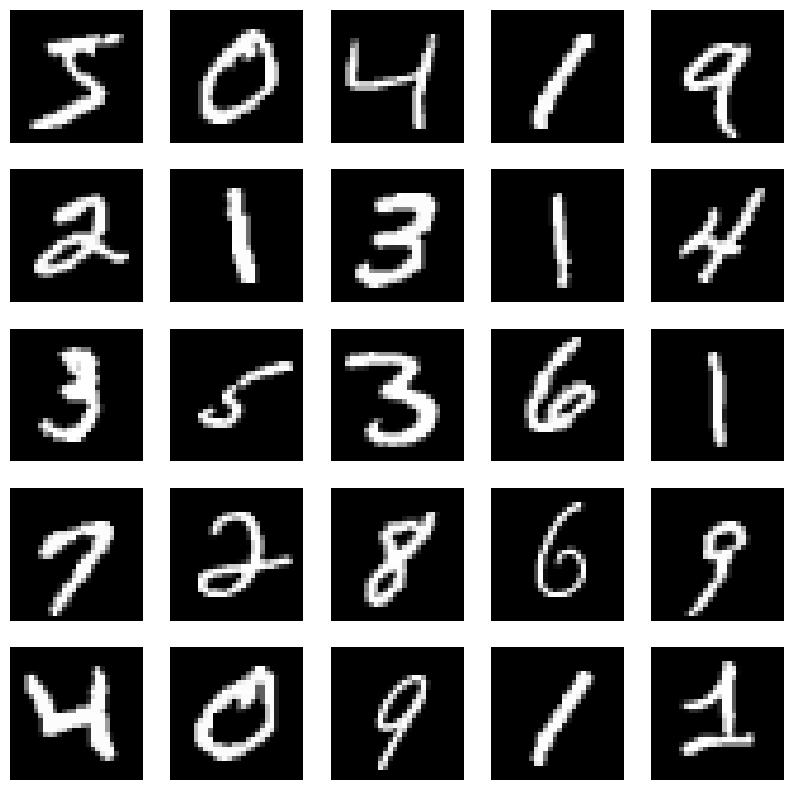

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i], cmap="gray")
  plt.axis("off")
plt.show()

## 3. Create a Data Pipeline

In [13]:
X_train.shape[0]

60000

In [14]:
# Normalise and reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
X_train = (X_train - 127.5) / 127.5

In [16]:
X_train.shape

(60000, 28, 28, 1)

In [15]:
#Ensures complete shuffling of the dataset every epoch for diverse trainin
BUFFER_SIZE = 60000
#Determines the number of images processed at once, balancing memory usage and training speed.
BATCH_SIZE = 128


In [17]:
X_train


array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

In [20]:
# Create the tensorflow dstaset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:

LATENT_DIM = 128
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

## 4. Create Generator and Discriminator

In [21]:
def build_generator():
  model = keras.Sequential([
    # Takes in random values and reshapes it to 7x7x256
    # Beginnings of a generated image
    layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,), kernel_initializer=WEIGHT_UNIT),
    layers.BatchNormalization(), # normalize the activation of the previous layer
    layers.LeakyReLU(),

    layers.Reshape((7, 7, 256)),

    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.01),

    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.01),

    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
  return model

generator = build_generator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,605,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 128)         │         409,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           3,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,888,832 (11.02 MB)

 Trainable params: 2,863,232 (10.92 MB)

 Non-trainable params: 25,600 (100.00 KB)

In [ ]:
img = generator.predict(np.random.randn(4,128))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


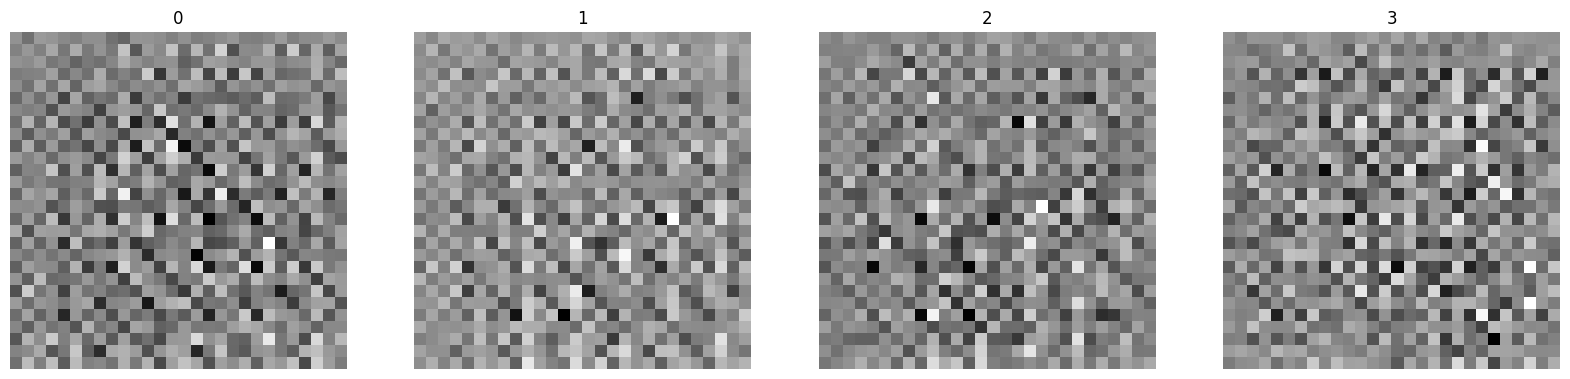

In [22]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img), cmap='gray')
    ax[idx].axis('off') #Hide axis
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

In [23]:
# build our discriminator
def build_discriminator():
  model = keras.Sequential([
      # First COnv2d layer: Detect low level features in the images (edges, textures, ...)
      layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),

      # LeakyRelu activation function to avoid dead neurons and allow negative gradients
      layers.LeakyReLU(0.2),
      # dropout to prevent overfitting and improve generalization
      layers.Dropout(0.3),

      # First COnv2d layer: learn more complex feature from the images
      layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.3),

      # Flatten the 2D feature maps into a 1D vector for the Dense layer
      layers.Flatten(),

      layers.Dense(1, activation='sigmoid')

  ])

  return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Construct training loop
Set up Loses and Optimizers

In [25]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
# Create the discriminator loss
def discriminator_loss(real_output, fake_output):
  # calculates the loss when the discriminator classify fake images
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)

  #calculate the loss when the discriminator classifies fake images
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

 # Return the sum of both losses
  return real_loss + fake_loss


In [27]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5, clipnorm=1.0)
#Small learning rate, which helps stabilize GAN training and prevent mode collapse. beta_1:controls the exponential decay rate for the first moment estimate
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5, clipnorm=1.0)

Building a Subclass model

In [28]:
# Building our sub ckass model
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    # initilize the GAN model  with the generator and discriminator
    super(GAN, self).__init__()
    self.generator = generator #set genrator model
    self.discriminator = discriminator # set discriminator moel


  def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer # set the generator optimizer
    self.d_optimizer = d_optimizer # set the discriminator optimizer
    self.g_loss = g_loss # set the generator loss
    self.d_loss = d_loss # set the discriminator loss


  def train_step(self, real_images):
    # Training logic
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as d_tape:
        generated_images = self.generator(noise)
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(generated_images)
        d_loss = self.d_loss(real_output, fake_output)

    # Computing the gradients for the discriminator based in its loss
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}



Build Callbacks

In [29]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, seed_dim=128):
    self.num_images = num_images
    self.seed_dim = seed_dim
    self.seed = tf.random.normal([num_images, seed_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5
      generated_images = tf.clip_by_value(generated_images, 0, 255)  # Ensure values are in [0, 255]
      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

## Train the dataset

In [30]:
gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - d_loss: 1.2020 - g_loss: 0.9001

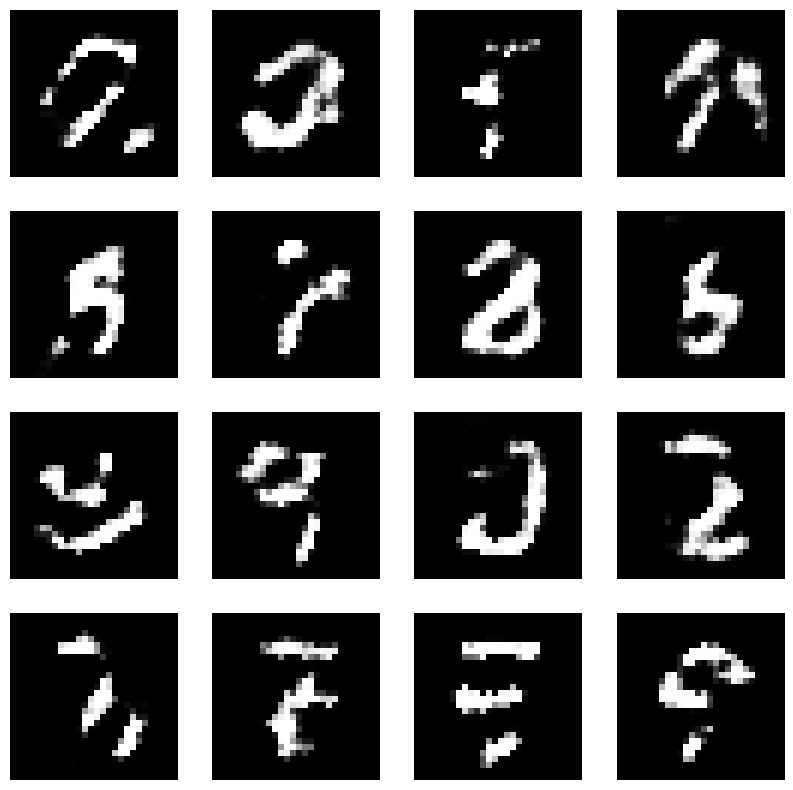

469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - d_loss: 1.2022 - g_loss: 0.8999
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - d_loss: 1.2833 - g_loss: 0.8655
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - d_loss: 1.3254 - g_loss: 0.8251
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3163 - g_loss: 0.8115
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.2959 - g_loss: 0.8217
Epoch 6/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.2826 - g_loss: 0.8396

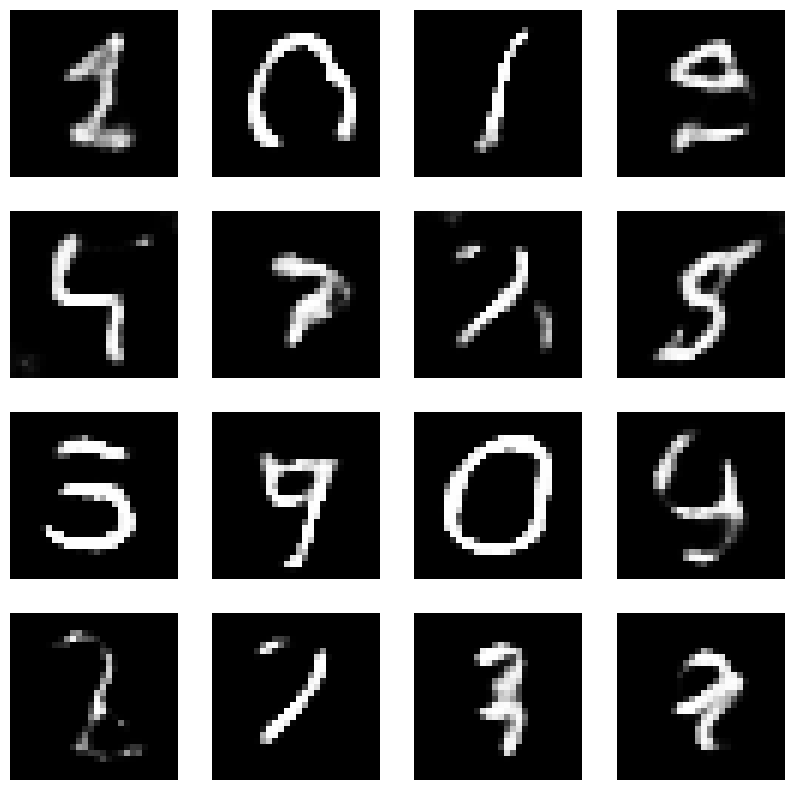

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.2833 - g_loss: 0.8391
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.2719 - g_loss: 0.8450
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.2743 - g_loss: 0.8315
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.2937 - g_loss: 0.8253
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - d_loss: 1.3071 - g_loss: 0.7965
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3210 - g_loss: 0.8067

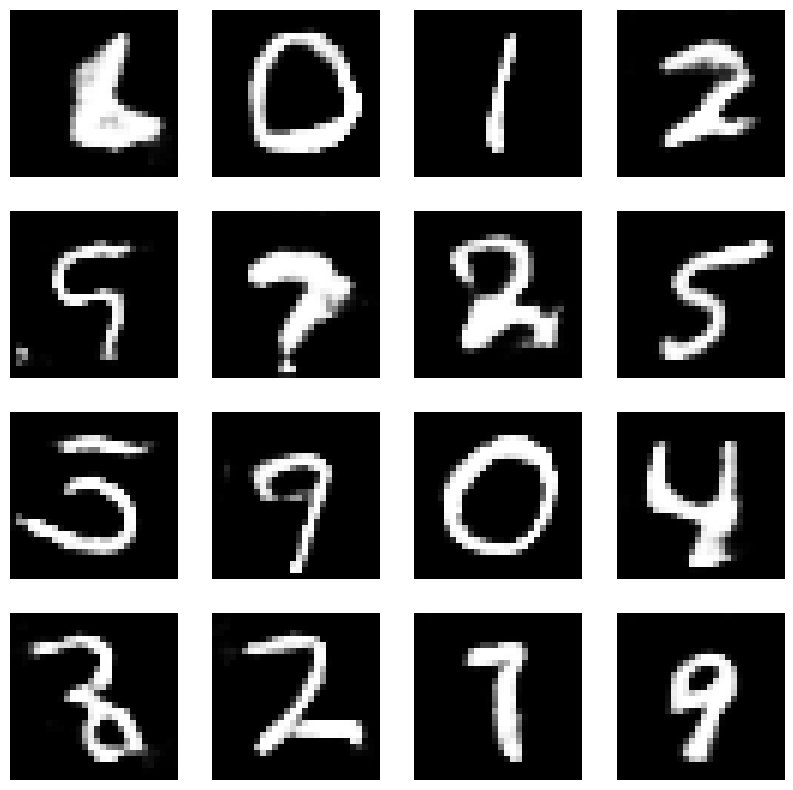

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - d_loss: 1.3210 - g_loss: 0.8064
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3252 - g_loss: 0.7825
Epoch 13/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3318 - g_loss: 0.7896
Epoch 14/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3344 - g_loss: 0.7831
Epoch 15/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - d_loss: 1.3337 - g_loss: 0.7681
Epoch 16/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3394 - g_loss: 0.7773

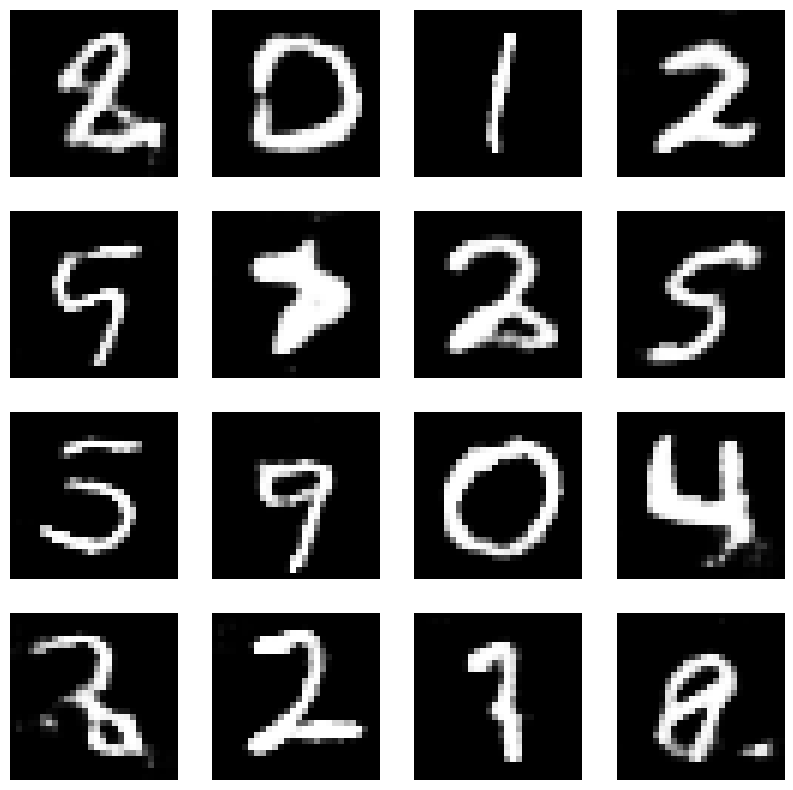

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - d_loss: 1.3393 - g_loss: 0.7771
Epoch 17/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3440 - g_loss: 0.7825
Epoch 18/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3396 - g_loss: 0.7669
Epoch 19/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3419 - g_loss: 0.7688
Epoch 20/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3421 - g_loss: 0.7648
Epoch 21/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3435 - g_loss: 0.7702

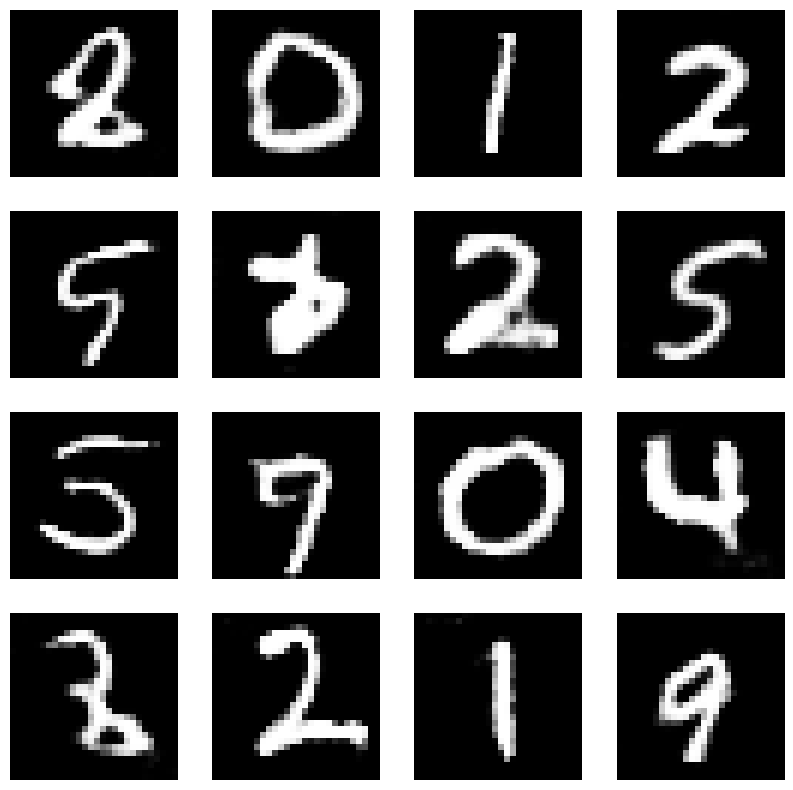

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - d_loss: 1.3434 - g_loss: 0.7702
Epoch 22/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3415 - g_loss: 0.7618
Epoch 23/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3422 - g_loss: 0.7650
Epoch 24/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.3441 - g_loss: 0.7665
Epoch 25/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - d_loss: 1.3421 - g_loss: 0.7606
Epoch 26/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3422 - g_loss: 0.7579

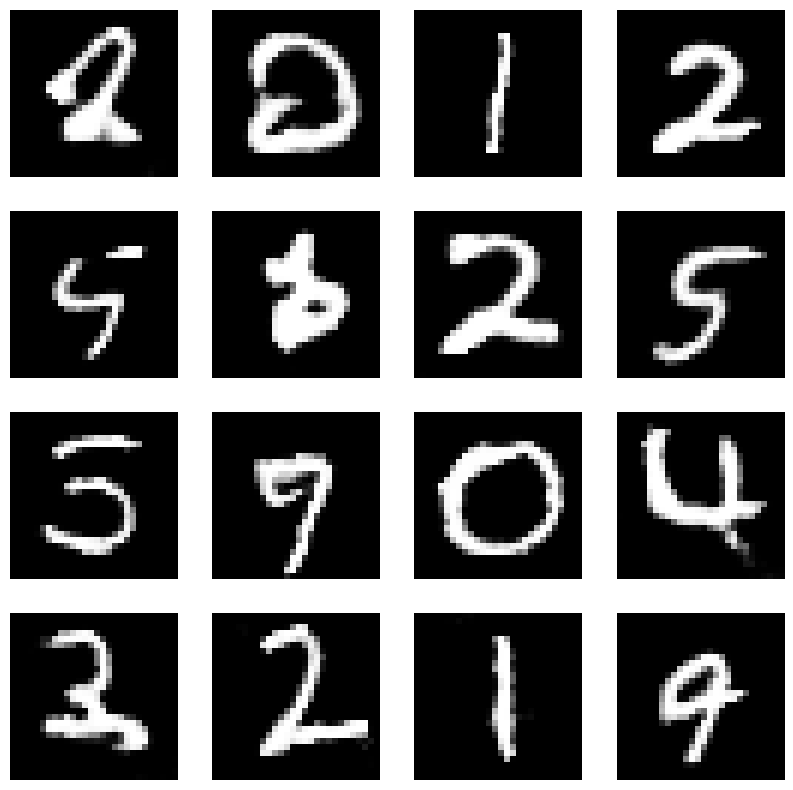

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.3423 - g_loss: 0.7581
Epoch 27/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3454 - g_loss: 0.7613
Epoch 28/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3448 - g_loss: 0.7558
Epoch 29/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3437 - g_loss: 0.7563
Epoch 30/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - d_loss: 1.3459 - g_loss: 0.7605
Epoch 31/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - d_loss: 1.3461 - g_loss: 0.7593

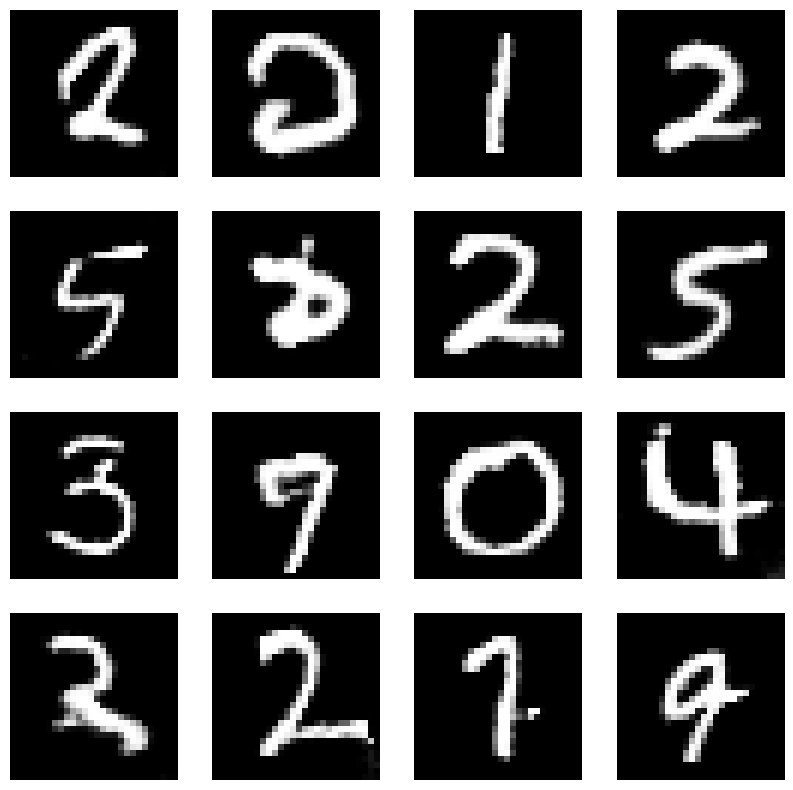

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - d_loss: 1.3459 - g_loss: 0.7597
Epoch 32/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3464 - g_loss: 0.7556
Epoch 33/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3459 - g_loss: 0.7544
Epoch 34/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3464 - g_loss: 0.7570
Epoch 35/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3463 - g_loss: 0.7567
Epoch 36/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - d_loss: 1.3458 - g_loss: 0.7569

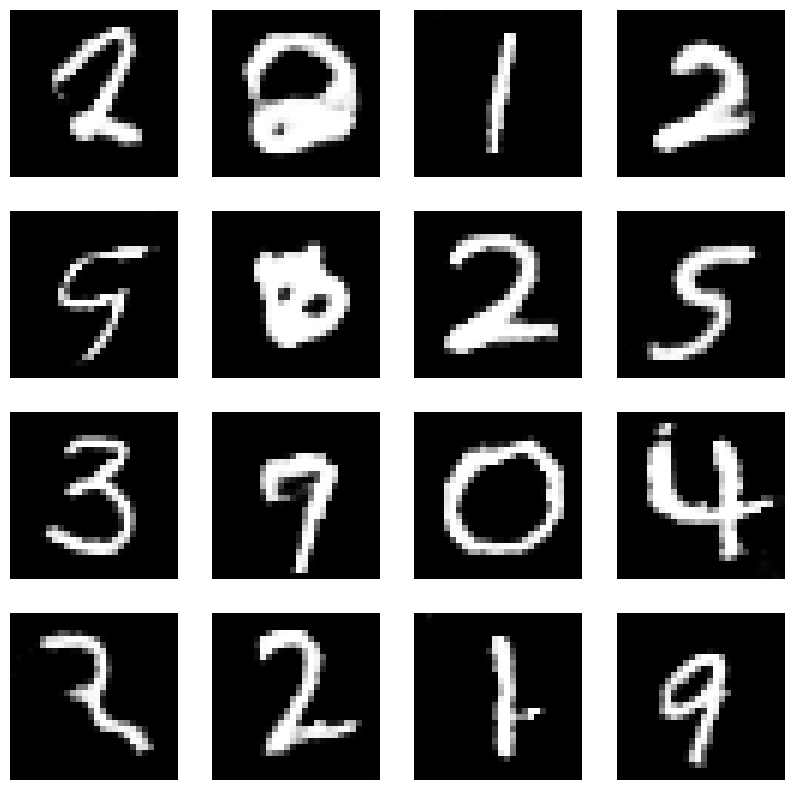

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - d_loss: 1.3456 - g_loss: 0.7570
Epoch 37/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3454 - g_loss: 0.7583
Epoch 38/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3458 - g_loss: 0.7589
Epoch 39/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3459 - g_loss: 0.7553
Epoch 40/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3466 - g_loss: 0.7554
Epoch 41/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3457 - g_loss: 0.7579

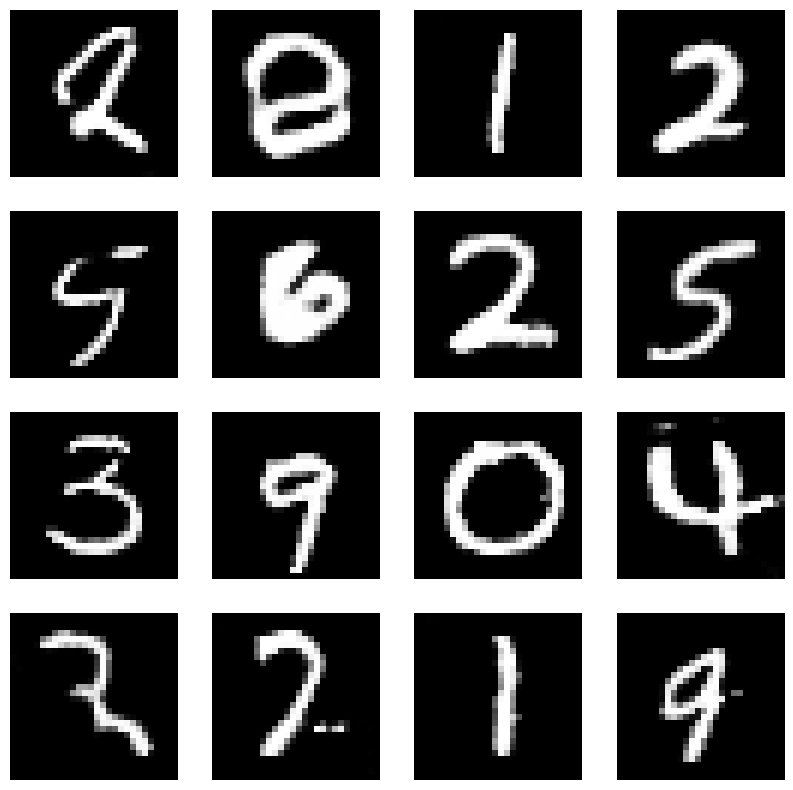

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.3456 - g_loss: 0.7580
Epoch 42/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3459 - g_loss: 0.7551
Epoch 43/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3455 - g_loss: 0.7559
Epoch 44/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3466 - g_loss: 0.7583
Epoch 45/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - d_loss: 1.3470 - g_loss: 0.7587
Epoch 46/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - d_loss: 1.3468 - g_loss: 0.7600

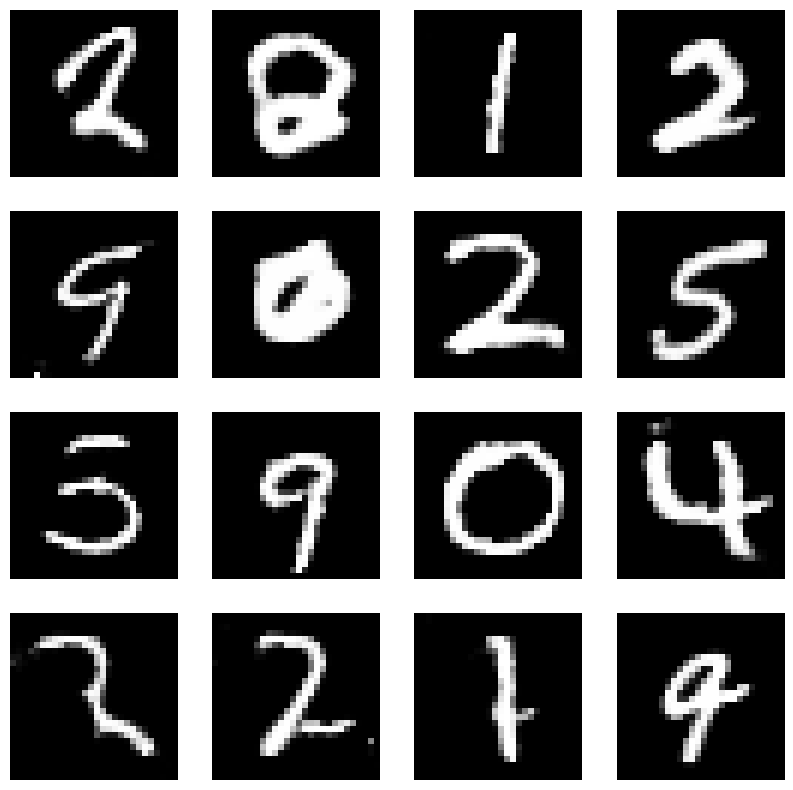

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - d_loss: 1.3467 - g_loss: 0.7598
Epoch 47/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - d_loss: 1.3462 - g_loss: 0.7539
Epoch 48/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3455 - g_loss: 0.7570
Epoch 49/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3472 - g_loss: 0.7577
Epoch 50/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3463 - g_loss: 0.7579
Epoch 51/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3474 - g_loss: 0.7607

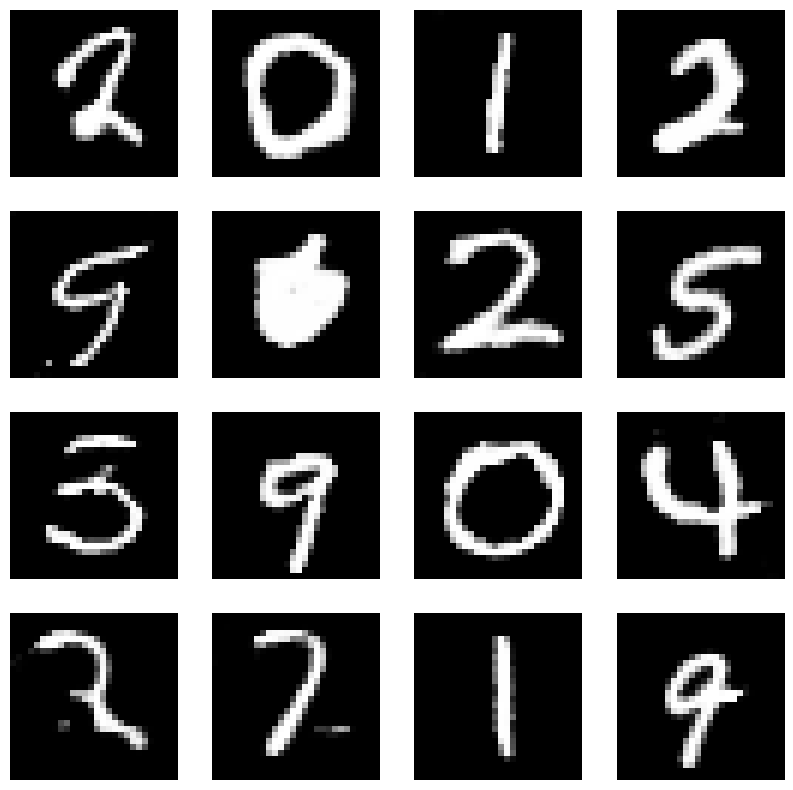

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - d_loss: 1.3475 - g_loss: 0.7607
Epoch 52/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3465 - g_loss: 0.7571
Epoch 53/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - d_loss: 1.3475 - g_loss: 0.7564
Epoch 54/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - d_loss: 1.3460 - g_loss: 0.7568
Epoch 55/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - d_loss: 1.3459 - g_loss: 0.7569
Epoch 56/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3457 - g_loss: 0.7577

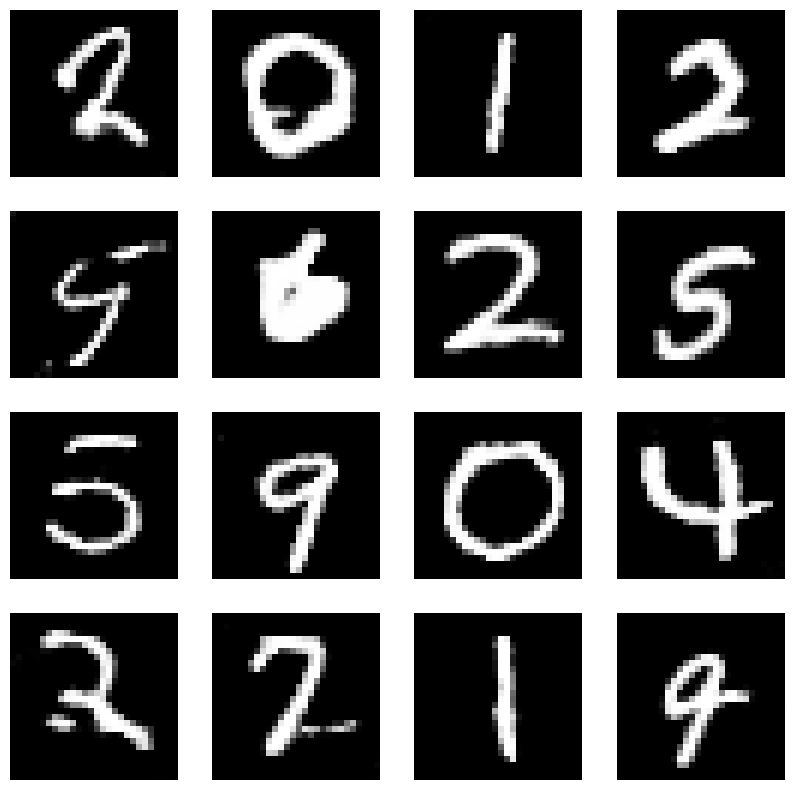

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - d_loss: 1.3457 - g_loss: 0.7575
Epoch 57/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - d_loss: 1.3474 - g_loss: 0.7597
Epoch 58/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3449 - g_loss: 0.7586
Epoch 59/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3456 - g_loss: 0.7570
Epoch 60/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3455 - g_loss: 0.7563
Epoch 61/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3471 - g_loss: 0.7620

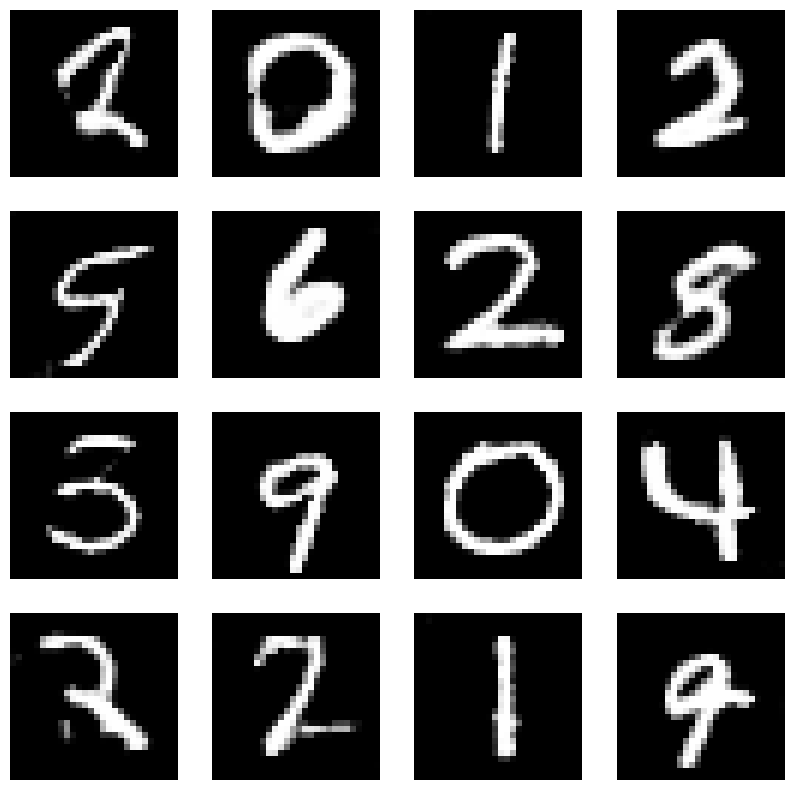

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - d_loss: 1.3470 - g_loss: 0.7620
Epoch 62/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3458 - g_loss: 0.7592
Epoch 63/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3477 - g_loss: 0.7599
Epoch 64/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3470 - g_loss: 0.7594
Epoch 65/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3479 - g_loss: 0.7583
Epoch 66/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3469 - g_loss: 0.7596

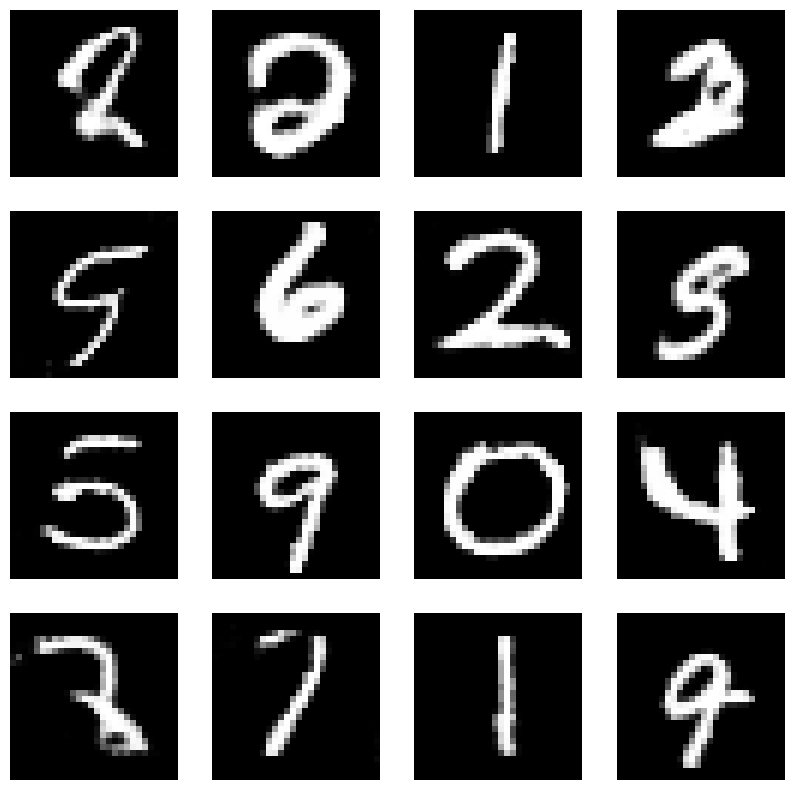

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - d_loss: 1.3469 - g_loss: 0.7596
Epoch 67/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3472 - g_loss: 0.7612
Epoch 68/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.3449 - g_loss: 0.7601
Epoch 69/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - d_loss: 1.3461 - g_loss: 0.7584
Epoch 70/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - d_loss: 1.3467 - g_loss: 0.7608
Epoch 71/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3467 - g_loss: 0.7587

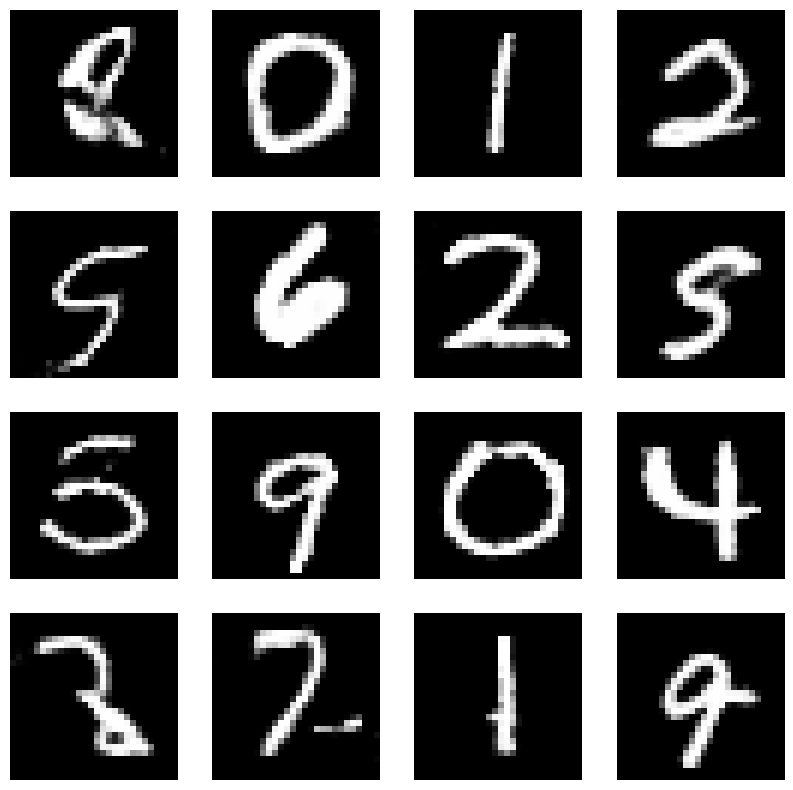

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.3467 - g_loss: 0.7587
Epoch 72/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3447 - g_loss: 0.7598
Epoch 73/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3462 - g_loss: 0.7597
Epoch 74/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3460 - g_loss: 0.7585
Epoch 75/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3453 - g_loss: 0.7590
Epoch 76/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3451 - g_loss: 0.7551

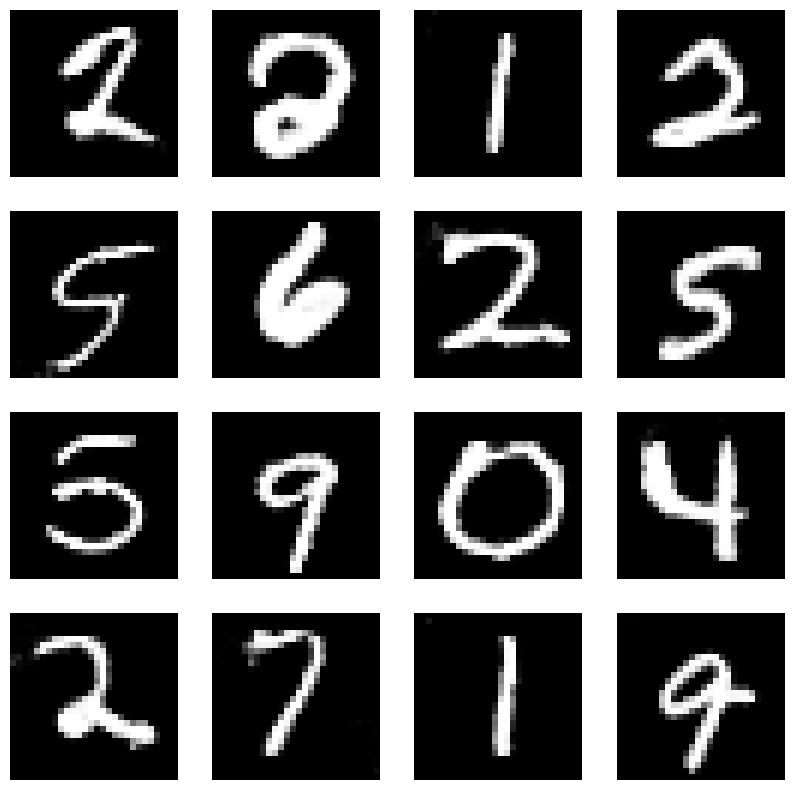

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - d_loss: 1.3451 - g_loss: 0.7554
Epoch 77/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3456 - g_loss: 0.7600
Epoch 78/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3460 - g_loss: 0.7618
Epoch 79/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3454 - g_loss: 0.7627
Epoch 80/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3449 - g_loss: 0.7585
Epoch 81/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3452 - g_loss: 0.7606

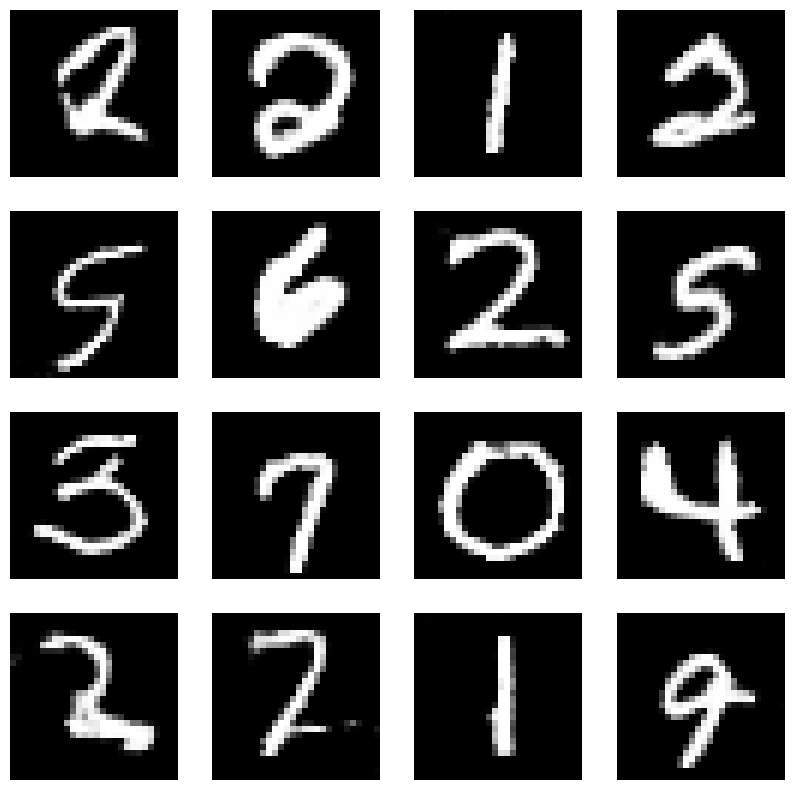

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - d_loss: 1.3452 - g_loss: 0.7604
Epoch 82/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3449 - g_loss: 0.7634
Epoch 83/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3447 - g_loss: 0.7616
Epoch 84/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3452 - g_loss: 0.7582
Epoch 85/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3443 - g_loss: 0.7601
Epoch 86/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - d_loss: 1.3441 - g_loss: 0.7629

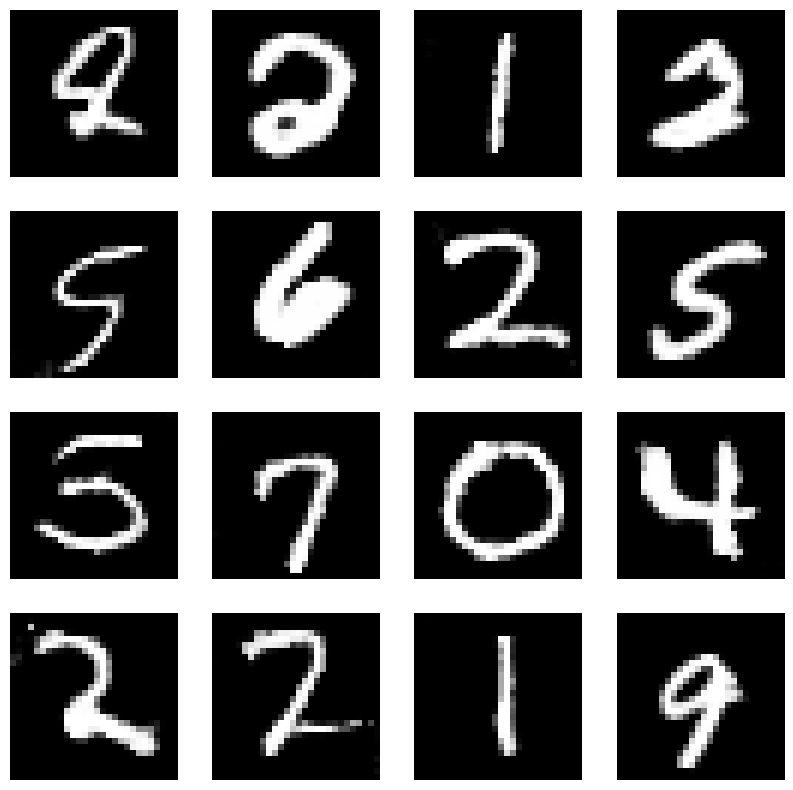

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.3443 - g_loss: 0.7628
Epoch 87/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3443 - g_loss: 0.7622
Epoch 88/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3437 - g_loss: 0.7635
Epoch 89/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3434 - g_loss: 0.7631
Epoch 90/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3458 - g_loss: 0.7612
Epoch 91/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - d_loss: 1.3438 - g_loss: 0.7637

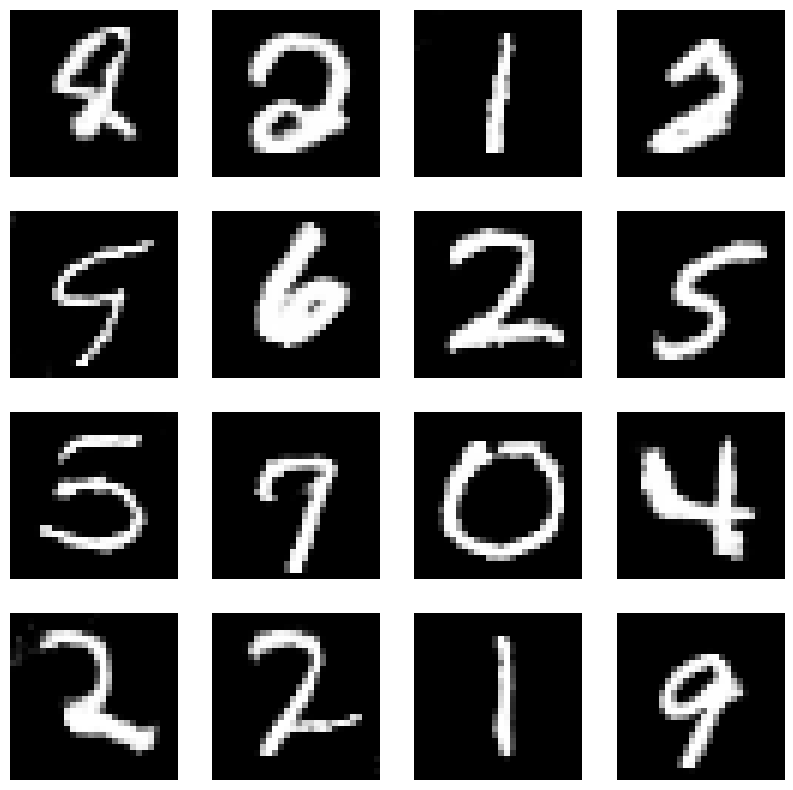

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.3437 - g_loss: 0.7636
Epoch 92/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - d_loss: 1.3444 - g_loss: 0.7642
Epoch 93/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3442 - g_loss: 0.7607
Epoch 94/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3424 - g_loss: 0.7613
Epoch 95/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.3430 - g_loss: 0.7613
Epoch 96/100
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - d_loss: 1.3436 - g_loss: 0.7665

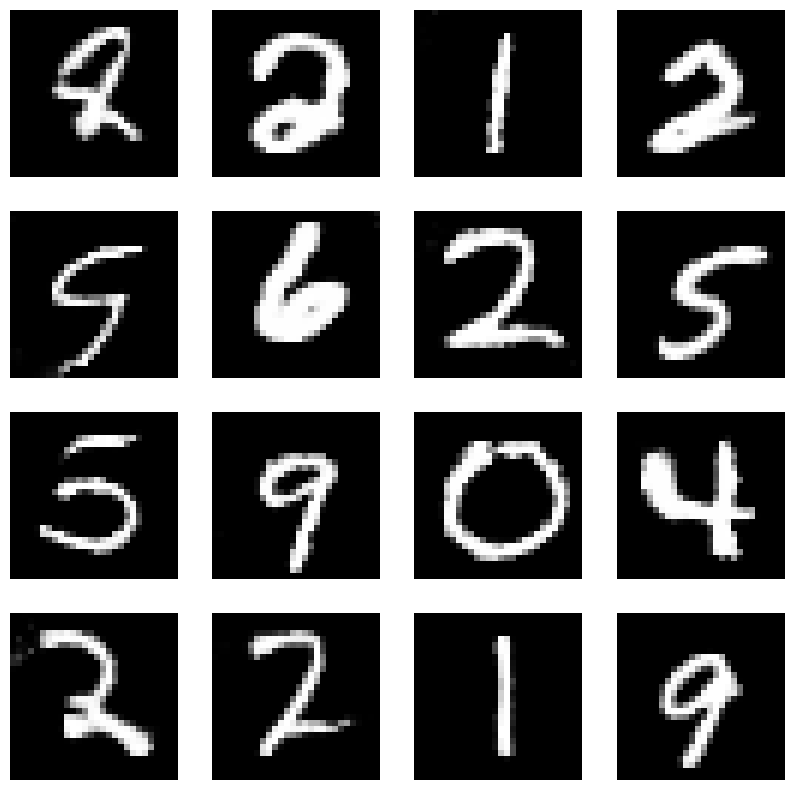

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - d_loss: 1.3436 - g_loss: 0.7665
Epoch 97/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3436 - g_loss: 0.7625
Epoch 98/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3441 - g_loss: 0.7647
Epoch 99/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - d_loss: 1.3437 - g_loss: 0.7649
Epoch 100/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - d_loss: 1.3413 - g_loss: 0.7643


In [ ]:
history = gan.fit(train_dataset, epochs=100, callbacks=[ImageCallback()])


## 6. Evaluate and save the model

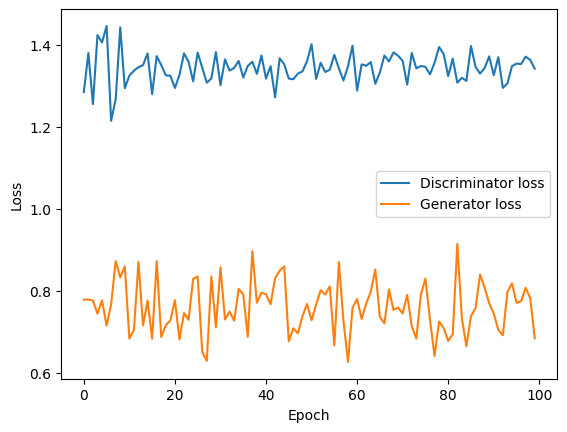

In [ ]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5 # denormalize

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

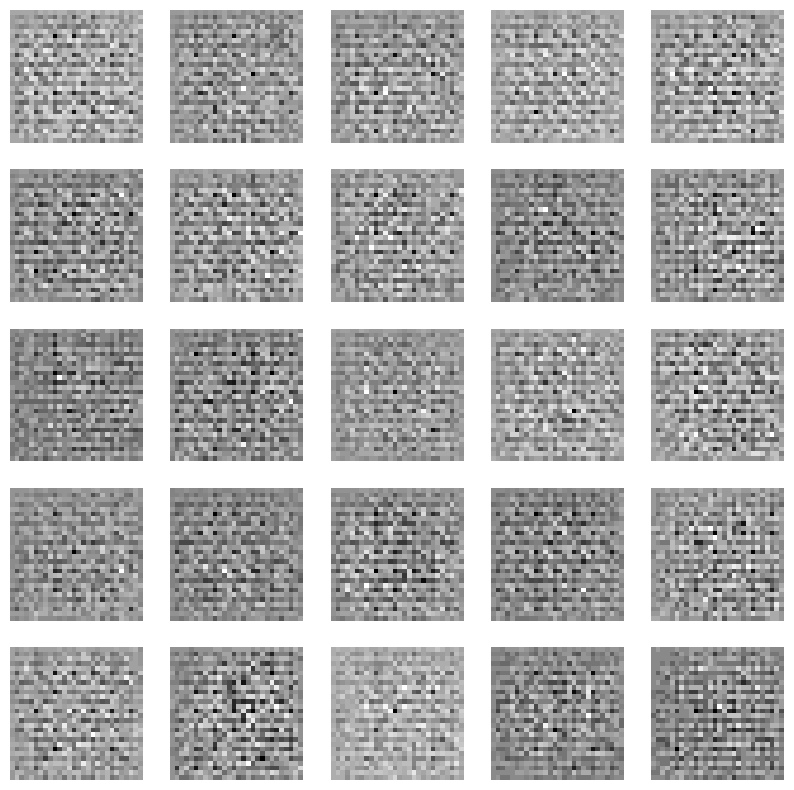

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
generator.save("/content/drive/My Drive/handwritten_recognition.h5")
